In [3]:
#used packages
import torch
import json
################################1. preparing the utilities functions to process our data
#Here we define the utilities function to process our data, i.e. nodes and edges and thier features (attributes)
#For representing this data in the PyG data format, we first define a method load_node_csv() that reads 
#in a *.csv file and returns a node-level feature representation x of shape [num_nodes, num_features]:

###############################1.1 function to Load node-realted data
#load_node_csv() reads the *.csv file from path, and creates a dictionary mapping that maps its index column 
#to a consecutive value e.g., the representation of a resource in the first row should be accessible via x[0].

def load_node_csv(path, index_col, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.stack(xs, dim=1)

    return x, mapping

################################################2.2 function to Load edge-related data
#loading of edges 
#load_edge_csv() returns the final edge_index representation of shape [2, number_of_each_edges_types] 
#from *.csv

def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  encoders=None, **kwargs):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)
    return edge_index, edge_attr
#src_index_col and dst_index_col define the index columns of source and destination nodes, 
#encoders are used to return additional edge-level feature information using one of NLP models


################################################1.3 function to define an encoder that applies on of NLP model to encode node/edgae related features 
from sentence_transformers import SentenceTransformer
class SequenceEncoder(object):
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()


class ProviderEncoder(object):
    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()
class TypeEncoder(object):
    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()

class LocationEncoder(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()

def load_labels(path):
##load the labels of services
      with open(path) as f:
        labels = json.load(f)
      return labels 
########################2) Load the data from the given dataset using the defined utilities functions

#steps:
#A) load graphs from CSV files 
from torch_geometric.data import download_url, extract_zip
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import os
def load_data(dir_path,labels,service_label): 
  providers = os.listdir(dir_path)
  data_set = []
  graph_mapping={}
  graph_i=0
  for provider in providers:
          services=os.listdir(dir_path+'/'+provider)
          for service in services:
                     service_files=os.listdir(dir_path+'/'+provider+'/'+service)
                     path=dir_path+'/'+provider+'/'+service+'/'
                     resource_path = path+'nodes.csv'
                     #1) load nodes
                     resource_x, resource_mapping = load_node_csv(
                     resource_path, index_col='resourceid', encoders={
                      'type': TypeEncoder(), 
                      'provider':ProviderEncoder()
                       
                       })
                      #initialize our HeteroData object and pass the node type into it
                     data= HeteroData()
                     data['resource'].x = resource_x
                                #2 load edges
                     for file in service_files:
                            if ('.csv' in file) and (file!='nodes.csv'):
                                    edge_path=path+file
                                    edge_index_relationship, edge_label_relationship= load_edge_csv(
                                    edge_path,
                                    src_index_col='resourceid',
                                    src_mapping=resource_mapping,
                                    dst_index_col='resourceid',
                                    dst_mapping=resource_mapping,
                                    encoders=None,)  
                                    relation_name=file.replace('.csv', '')
                                    data['resource', relation_name, 'resource'].edge_index =  edge_index_relationship
    
                     data.y=torch.tensor(int(labels[provider+'_'+service_label]), dtype=torch.long) 
                     data_set.append(data)
                     graph_i+=1


  return data_set

In [4]:
#Generate training data
import random
import os
##Put here the path of dataset
current_folder = 'C:/env/model_GNN'

label_path = os.path.join(current_folder, 'Heterogeneous_Graph_Learning/dataset/service_labels.json')
labels=load_labels(label_path)
#dir_path=r'Heterogeneous_Graph_Learning/dataset/services/'
dir_path=os.path.join(current_folder,'Heterogeneous_Graph_Learning/dataset/services/')

#will generate dataset for each service so that we can organize the finale dataset into training and testing in a fair way
L2B_graphs_path =dir_path+'L2bridging'
L2C_graphs_path =dir_path+'L2Connectivity'
L2E_graphs_path =dir_path+'L2endpoint'
L3R_graphs_path =dir_path+'L3routing'
NIC_graphs_path =dir_path+'NIC'
#Peering_graphs_path =dir_path+'peering_services' (Removed for now)

L2B_services=load_data(L2B_graphs_path,labels,'L2bridging')#
L2C_services=load_data(L2C_graphs_path,labels,'L2Connectivity')#
L2E_services=load_data(L2E_graphs_path,labels,'L2endpoint')#
L3R_services=load_data(L3R_graphs_path,labels,'L3routing')#
NIC_services=load_data(NIC_graphs_path,labels,'NIC')#
#Peering_services=load_data(Peering_graphs_path,labels)# (Removed for now)








In [5]:
#shuffling datac
random.shuffle(L2B_services)
random.shuffle(L2C_services)
random.shuffle(L2E_services)
random.shuffle(L3R_services)
random.shuffle(NIC_services)

#training
training_data_set=L2B_services[:250]+L2C_services[:250]+L2E_services[:250]+L3R_services[:60]+NIC_services[:250]
#+Peering_services[:300]
random.shuffle(training_data_set)
#testing 

testing_data_set=L2B_services[250:]+L2C_services[250:]+L2E_services[250:]+L3R_services[60:]+NIC_services[250:]

random.shuffle(testing_data_set)


In [6]:
##3 Add all data into data-loader for preparing the trainning and testing 
training_loader = DataLoader(training_data_set, batch_size=128)
Testing_loader = DataLoader(testing_data_set, batch_size=128)


In [7]:
graph = torch.load('AugmentedGNN.pt')


FileNotFoundError: [Errno 2] No such file or directory: 'AugmentedGNN.pt'

In [8]:
graphs=[]


In [9]:
len(graphs)


0

In [10]:
for elemnt in training_data_set:
    graphs.append(elemnt)


In [11]:
print(len(graphs))

1060


In [12]:
for element in graph:
    graphs.append(element)

NameError: name 'graph' is not defined

In [13]:
print(len(graphs))

1060


In [ ]:
train_size=int(0.7*len(graphs))
augmented_training_set=training_data_set
augmented_testing_set=testing_data_set
augmented_training_set.extend(graphs[:train_size])
augmented_testing_set.extend(graphs[train_size:])
print(len(augmented_training_set))
print(len(augmented_testing_set))

2754
1028


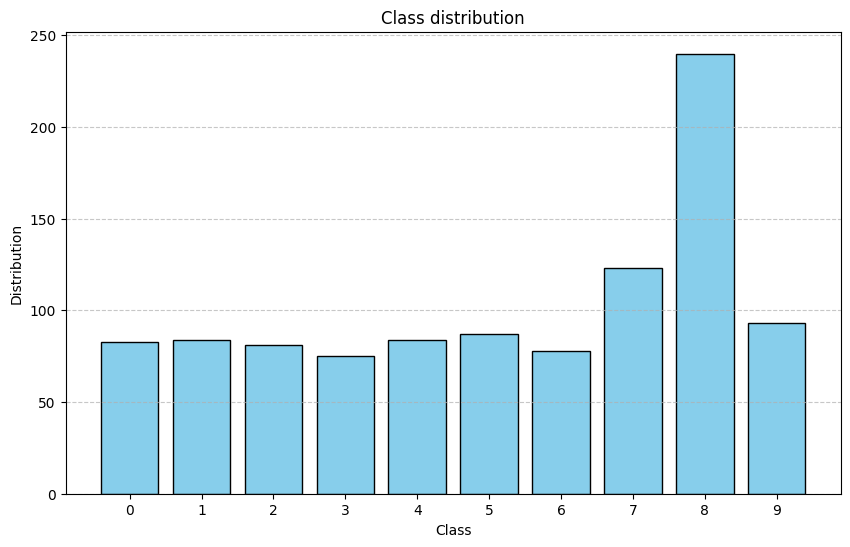

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
y_values = [data.y.item() for data in augmented_testing_set] 
occurrence_count = Counter(y_values)
labels, counts = zip(*occurrence_count.items())
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue', edgecolor='black')
plt.title("Class distribution")
plt.xlabel('Class')
plt.ylabel("Distribution")
plt.xticks(labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
##3 Add all data into data-loader for preparing the trainning and testing 
augmented_training_loader = DataLoader(augmented_training_set, batch_size=16)
augmented_testing_loader = DataLoader(augmented_testing_set, batch_size=16)


2754
1028


In [ ]:
def custom_global_mean_pool(x, batch):
    sum_embeddings = torch.zeros(batch.max().item() + 1, x.size(1), dtype=x.dtype, device=x.device)
    count_nodes = torch.zeros(batch.max().item() + 1, dtype=torch.int64, device=x.device)
    
    for node_idx in range(x.size(0)):
        sum_embeddings[batch[node_idx]] += x[node_idx]
        count_nodes[batch[node_idx]] += 1
    
    mean_embeddings = sum_embeddings / count_nodes.unsqueeze(1).to(torch.float)
    
    return mean_embeddings

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, to_hetero

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 10)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN(hidden_channels=64)
model = to_hetero(model, testing_data_set[0].metadata(), aggr='sum')
print(model)


GraphModule(
  (conv1): ModuleDict(
    (resource__Belong_To__resource): GCNConv(2, 64)
    (resource__exposes_resource_L2Address__resource): GCNConv(2, 64)
    (resource__exposes_resource_L3Address__resource): GCNConv(2, 64)
    (resource__exposes_resource_L3SimpleRoute__resource): GCNConv(2, 64)
    (resource__exposes_resource_Subnet__resource): GCNConv(2, 64)
    (resource__Hosted_On_L2Domain__resource): GCNConv(2, 64)
    (resource__Hosted_On_L3Domain__resource): GCNConv(2, 64)
    (resource__Hosted_On_Node__resource): GCNConv(2, 64)
    (resource__Is_Owned_By__resource): GCNConv(2, 64)
    (resource__requires_service__resource): GCNConv(2, 64)
    (resource__Require_Resource_Subnet__resource): GCNConv(2, 64)
  )
  (conv2): ModuleDict(
    (resource__Belong_To__resource): GCNConv(64, 64)
    (resource__exposes_resource_L2Address__resource): GCNConv(64, 64)
    (resource__exposes_resource_L3Address__resource): GCNConv(64, 64)
    (resource__exposes_resource_L3SimpleRoute__resource):

In [ ]:
def custom_model(model,batch): 
    x=model(batch.x_dict, batch.edge_index_dict)
    h = custom_global_mean_pool(x['resource'], batch.batch_dict['resource'])
    h = F.dropout(h, p=0.5, training=model.training)
    x = model.lin(h)
    return x, h

In [ ]:
#Here just we do a small training test
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#0.001
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
import torch
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    total_examples = 0
    total_loss = 0.0

    for batch in training_loader:
        optimizer.zero_grad()
        batch = batch.to('cpu')  # Move batch to CPU if necessary

        # Get model output and node embeddings
        out, h = custom_model(model, batch)

        # Compute the loss using Cross Entropy Loss
        loss = criterion(out, batch.y)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Optimizer step

        total_examples += batch.num_graphs  # Accumulate number of graphs processed
        total_loss += loss.item() * batch.num_graphs  # Accumulate total loss

    return total_loss / total_examples  # Return average loss per example

# Assuming you have a training_loader set up
for epoch in range(1, 5):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 10.4080
Epoch: 002, Loss: 3.0314
Epoch: 003, Loss: 1.9794
Epoch: 004, Loss: 1.6402


In [ ]:
def test(loader):
    model.eval()
    correct = 0
    embeddings=[]
    data_outs=[]
    data_outs_embedding=[]
    for data in loader:  # Iterate in batches over the training/test dataset.
         out, h = custom_model(model, data)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += (pred == data.y).sum().item()  # Check against ground-truth labels
         embeddings.extend(element for element in h)
         data_outs.extend(element for element in pred)
         data_outs_embedding.extend( element for element in out)
        
    return correct / len(loader.dataset), embeddings, data_outs, data_outs_embedding# Derive ratio of correct predictions.

In [ ]:
for epoch in range(1, 20): 
    loss=train()
    print(f'Epoch: {epoch:03d}')
    print ('losss')
    print (loss)
    train_acc, train_embeddings, train_data_outs,train_data_outs_embeddings= test(augmented_training_loader)
    test_acc, test_embeddings, test_data_outs, test_data_outs_embeddings= test(augmented_testing_loader)
    print(f'Train Accuracy: {train_acc:.4f},Test Acc: {test_acc:.4f}')        



Epoch: 001
losss
1.4015709126264009
Train Accuracy: 0.2887,Test Acc: 0.3473
Epoch: 002
losss
1.921207908451687
Train Accuracy: 0.5156,Test Acc: 0.5311
Epoch: 003
losss
1.16467649657915
Train Accuracy: 0.6496,Test Acc: 0.4222
Epoch: 004
losss
0.9416783236903217
Train Accuracy: 0.7229,Test Acc: 0.5982
Epoch: 005
losss
0.8824707651449963
Train Accuracy: 0.6314,Test Acc: 0.5593
Epoch: 006
losss
0.8003097024618411
Train Accuracy: 0.6314,Test Acc: 0.5603
Epoch: 007
losss
0.7424515704790059
Train Accuracy: 0.8174,Test Acc: 0.6333
Epoch: 008
losss
0.6747387893492534
Train Accuracy: 0.8177,Test Acc: 0.6323
Epoch: 009
losss
0.6381963705272024
Train Accuracy: 0.9078,Test Acc: 0.6702
Epoch: 010
losss
0.5891013477882269
Train Accuracy: 0.9074,Test Acc: 0.6693
Epoch: 011
losss
0.559104681880732
Train Accuracy: 0.9085,Test Acc: 0.6780
Epoch: 012
losss
0.5579230330002507
Train Accuracy: 0.8827,Test Acc: 0.6625
Epoch: 013
losss
0.5206323005881272
Train Accuracy: 0.8929,Test Acc: 0.7023
Epoch: 014
losss

In [ ]:
for epoch in range(1, 5): 
    loss=train()
    print(f'Epoch: {epoch:03d}')
    print ('losss')
    print (loss)
    train_acc, train_embeddings, train_data_outs,train_data_outs_embeddings= test(training_loader)
    test_acc, test_embeddings, test_data_outs, test_data_outs_embeddings= test(Testing_loader)
    print(f'Train Accuracy: {train_acc:.4f},Test Acc: {test_acc:.4f}')        



Epoch: 001
losss
0.8194510873758568
Train Accuracy: 0.9434,Test Acc: 0.9302
Epoch: 002
losss
0.7482615983711098
Train Accuracy: 0.9802,Test Acc: 0.9767
Epoch: 003
losss
0.6868139141010788
Train Accuracy: 0.9434,Test Acc: 0.9302
Epoch: 004
losss
0.6168860228556508
Train Accuracy: 0.9802,Test Acc: 0.9767


In [ ]:
print(train_data_outs_embeddings)

[tensor([-4.3212,  7.5269, -1.1876, 10.3951, -5.1958,  0.2787,  1.2606,  6.7774,
        -4.5723, -5.0166], grad_fn=<UnbindBackward0>), tensor([ 5.6141, -0.9379,  6.6185, -1.1110, -0.1936, -3.3754,  4.5490, -0.3843,
        -0.2204, -2.4845], grad_fn=<UnbindBackward0>), tensor([  8.0848,   0.7394,   1.5495,  -7.4586,  13.0002,   3.4872, -11.7560,
        -11.0174,  10.4722,   4.7017], grad_fn=<UnbindBackward0>), tensor([-2.8901,  9.8980, -1.1064,  7.5260, -2.6498,  4.3220, -0.8952,  0.9433,
        -2.4652, -1.3503], grad_fn=<UnbindBackward0>), tensor([-4.3212,  7.5269, -1.1876, 10.3951, -5.1958,  0.2787,  1.2606,  6.7774,
        -4.5723, -5.0166], grad_fn=<UnbindBackward0>), tensor([  2.7044,  10.7443,  -2.2416,  -2.8748,   7.6262,  16.3661,  -8.8973,
        -15.5095,   5.8733,  11.1055], grad_fn=<UnbindBackward0>), tensor([  8.0848,   0.7394,   1.5495,  -7.4586,  13.0002,   3.4872, -11.7560,
        -11.0174,  10.4722,   4.7017], grad_fn=<UnbindBackward0>), tensor([  8.6704,   0.25

In [ ]:
print ("train output service labels")
train_data_lables = torch.tensor(train_data_outs)
#torch.cat(train_data_outs, dim=0)
print(train_data_lables)

print ("test output service labels")
test_data_lables = torch.tensor(test_data_outs)
print(test_data_lables)


print('######################################train out embeddings#######')
#print(train_data_outs_embeddings)

print('######################################test out embeddings#######')
#print(test_data_outs_embeddings)


print('###############################train embeddings#############################')
#print(train_embeddings)


print('###############################test embeddings#############################')
#print(test_embeddings)
train_data_outs_embeddings_serializable = [tensor.tolist() for tensor in train_data_outs_embeddings]
test_data_outs_embeddings_serializable = [tensor.tolist() for tensor in test_data_outs_embeddings]
train_embeddings_serializable = [tensor.tolist() for tensor in train_embeddings]
test_embeddings_serializable = [tensor.tolist() for tensor in test_embeddings]
# Convert tensors to lists
train_data_outs_list = [tensor.tolist() for tensor in train_data_outs]
test_data_outs_list = [tensor.tolist() for tensor in test_data_outs]
####################save services labels+services embedings+out_embedding for future clutring 
jsonFile = open("C:/env/model_GNN/correction/train_data_outs_embedding.json", "w") 
jsonFile.write(json.dumps(train_data_outs_embeddings_serializable))
jsonFile.close()

# Convert tensors to lists


# Save to JSON files
with open("C:/env/model_GNN/correction/test_data_outs_embedding.json", "w") as jsonFile:
    jsonFile.write(json.dumps(test_data_outs_embeddings_serializable))

with open("C:/env/model_GNN/correction/train_embeddings.json", "w") as jsonFile:
    jsonFile.write(json.dumps(train_embeddings_serializable))

with open("C:/env/model_GNN/correction/test_embeddings.json", "w") as jsonFile:
    jsonFile.write(json.dumps(test_embeddings_serializable))

with open("C:/env/model_GNN/correction/train_data_lables.json", "w") as jsonFile:
    jsonFile.write(json.dumps(train_data_outs_list))

with open("C:/env/model_GNN/correction/test_data_lables.json", "w") as jsonFile:
    jsonFile.write(json.dumps(test_data_outs_list))

###convert list of embedddings to tensor of shape(number_of_data, number_of_features_to_encode_eachdata)

print('###############################embeddings concetanted#############################')
tensor_train_embeddings =  [torch.tensor(element) for element in train_embeddings]
tensor_test_embeddings =  [torch.tensor(element) for element in test_embeddings]

tensor_train_data_outs_embedding=[torch.tensor(element) for element in train_data_outs_embeddings]
tensor_test_data_outs_embedding=[torch.tensor(element) for element in test_data_outs_embeddings]

print(len(tensor_train_embeddings))
print(len(tensor_test_embeddings))
print(len(tensor_train_data_outs_embedding))
print(len(tensor_test_data_outs_embedding))



train output service labels
tensor([7, 2, 1,  ..., 9, 6, 9])
test output service labels
tensor([3, 3, 1,  ..., 6, 0, 0])
######################################train out embeddings#######
######################################test out embeddings#######
###############################train embeddings#############################
###############################test embeddings#############################
###############################embeddings concetanted#############################
2754
1028
2754
1028


c:\env\lib\site-packages\ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\env\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\env\lib\site-packages\ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\env\lib\site-packages\ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def visualize_embedding(h, color, epoch=None, loss=None):
    """
    Visualizes embeddings with a scatter plot and includes a legend.
    
    Args:
        h (list of tensors): List of tensor embeddings to visualize.
        color (list): List of colors corresponding to the data points.
        epoch (int, optional): Epoch number for the plot title.
        loss (float, optional): Loss value for the plot title.
    """
    # Convert tensor to numpy array
    h = torch.stack(h).detach().cpu().numpy()

    # Create a figure
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    # Scatter plot with darker colors
    scatter = plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Dark2", alpha=0.8)

    # Create a legend
    unique_labels = np.unique(color)
    print("unique",unique_labels)
    colormap = plt.cm.get_cmap("Dark2", len(unique_labels))
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i / len(unique_labels)), markersize=10) for i in range(len(unique_labels))]
    plt.legend(handles, [f'Label {label}' for label in unique_labels], title="Labels", fontsize=12, title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add epoch and loss information if provided
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)

    plt.show()

def visualize(h, color):
    """
    Visualizes embeddings with TSNE and adds a color legend.
    
    Args:
        h (list of tensors): List of tensor embeddings to visualize.
        color (list): List of colors corresponding to the data points.
    """
    # Convert tensor to numpy array and apply TSNE
    h = torch.stack(h).detach().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(h)

    # Create a figure
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    # Scatter plot with darker colors
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Dark2", alpha=0.8)

    # Create a legend
    unique_labels = np.unique(color)
    print("unique",unique_labels)

    colormap = plt.cm.get_cmap("Dark2", len(unique_labels))
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i / len(unique_labels)), markersize=10) for i in range(len(unique_labels))]
    print(handles)
    plt.legend(handles, [f'Label {label}' for label in unique_labels], title="Labels", fontsize=12, title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()




Embedding length: 2754
1
(2754,)


c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


unique [0 1 2 3 4 5 6 7 8 9]
[<matplotlib.lines.Line2D object at 0x000002C40AD2BFC8>, <matplotlib.lines.Line2D object at 0x000002C46772F108>, <matplotlib.lines.Line2D object at 0x000002C478B82348>, <matplotlib.lines.Line2D object at 0x000002C478B82D48>, <matplotlib.lines.Line2D object at 0x000002C478B82E48>, <matplotlib.lines.Line2D object at 0x000002C476C70648>, <matplotlib.lines.Line2D object at 0x000002C478B82408>, <matplotlib.lines.Line2D object at 0x000002C467622348>, <matplotlib.lines.Line2D object at 0x000002C467622708>, <matplotlib.lines.Line2D object at 0x000002C478B82EC8>]


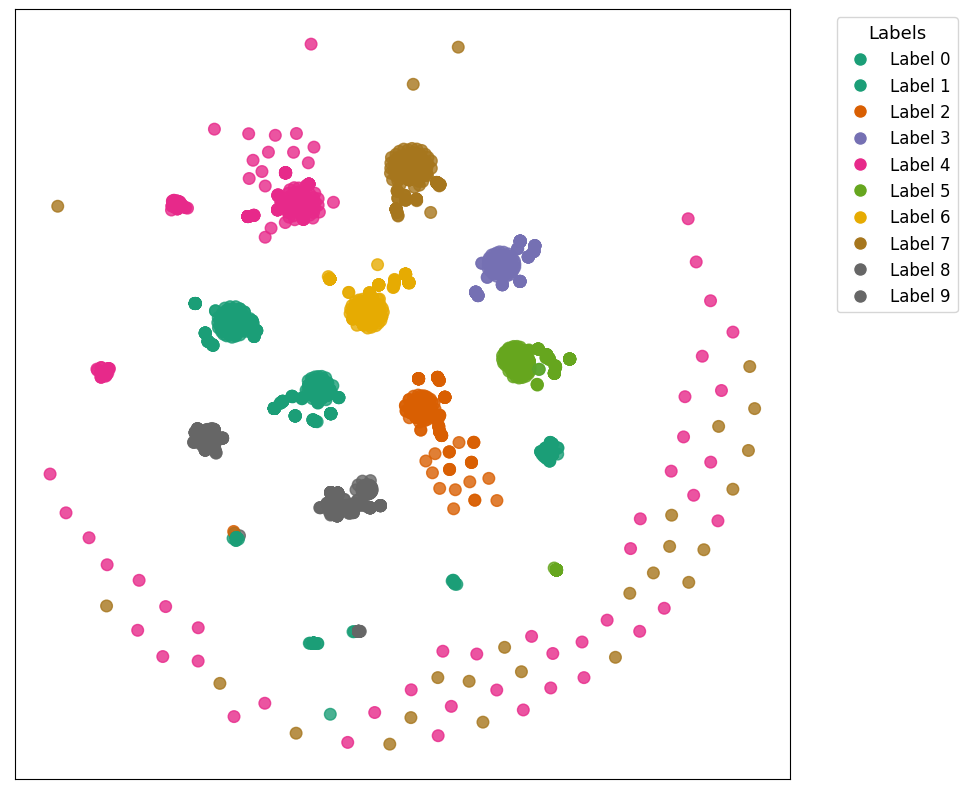

In [ ]:
#embeding after training

print(f'Embedding length: {len(tensor_train_embeddings)}')
color=np.array(train_data_lables)
k=0
for i in color:
    if i==8:
        k=+1
print(k)
print(color.shape)
visualize(tensor_train_embeddings, color)



Embedding shape: 1028
(1028,)


c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


unique [0 1 2 3 4 5 6 7 8 9]
[<matplotlib.lines.Line2D object at 0x000002C478B1FB08>, <matplotlib.lines.Line2D object at 0x000002C476C5D848>, <matplotlib.lines.Line2D object at 0x000002C47B3CF708>, <matplotlib.lines.Line2D object at 0x000002C47B3CFE08>, <matplotlib.lines.Line2D object at 0x000002C47B3CFB88>, <matplotlib.lines.Line2D object at 0x000002C47B047648>, <matplotlib.lines.Line2D object at 0x000002C47B3CF788>, <matplotlib.lines.Line2D object at 0x000002C47B047088>, <matplotlib.lines.Line2D object at 0x000002C47B0478C8>, <matplotlib.lines.Line2D object at 0x000002C47B3CFFC8>]


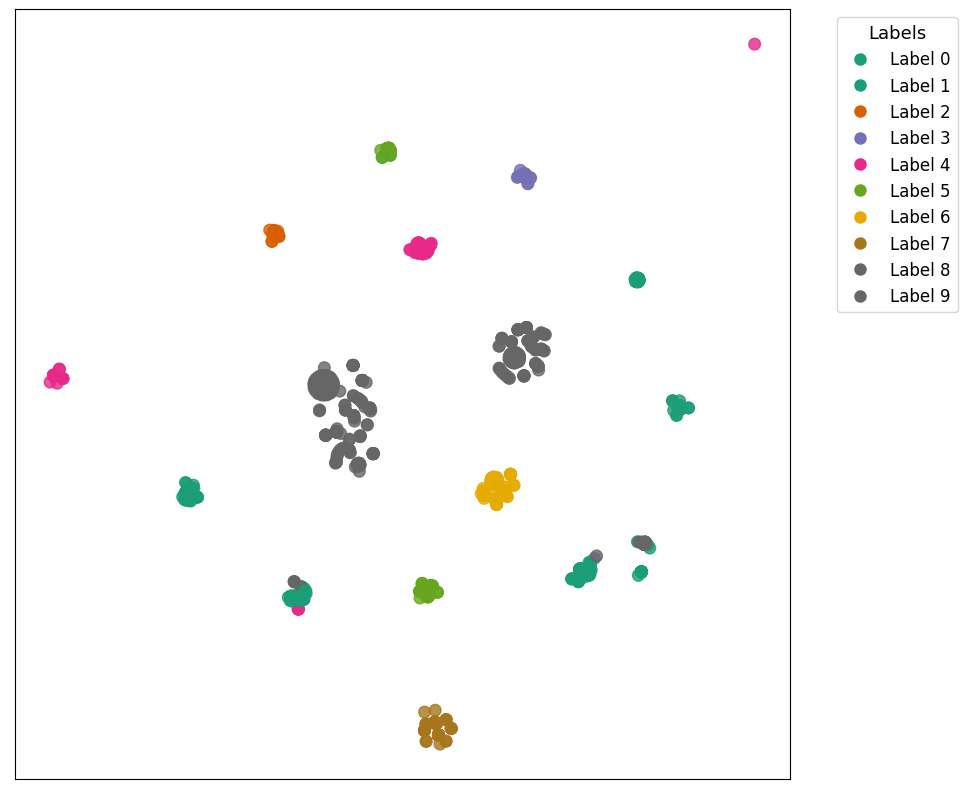

In [ ]:
print(f'Embedding shape: {len(tensor_test_embeddings)}')
color=np.array(test_data_lables)
print(color.shape)
visualize(tensor_test_embeddings, color)

unique [0 1 2 3 4 5 6 7 8 9]


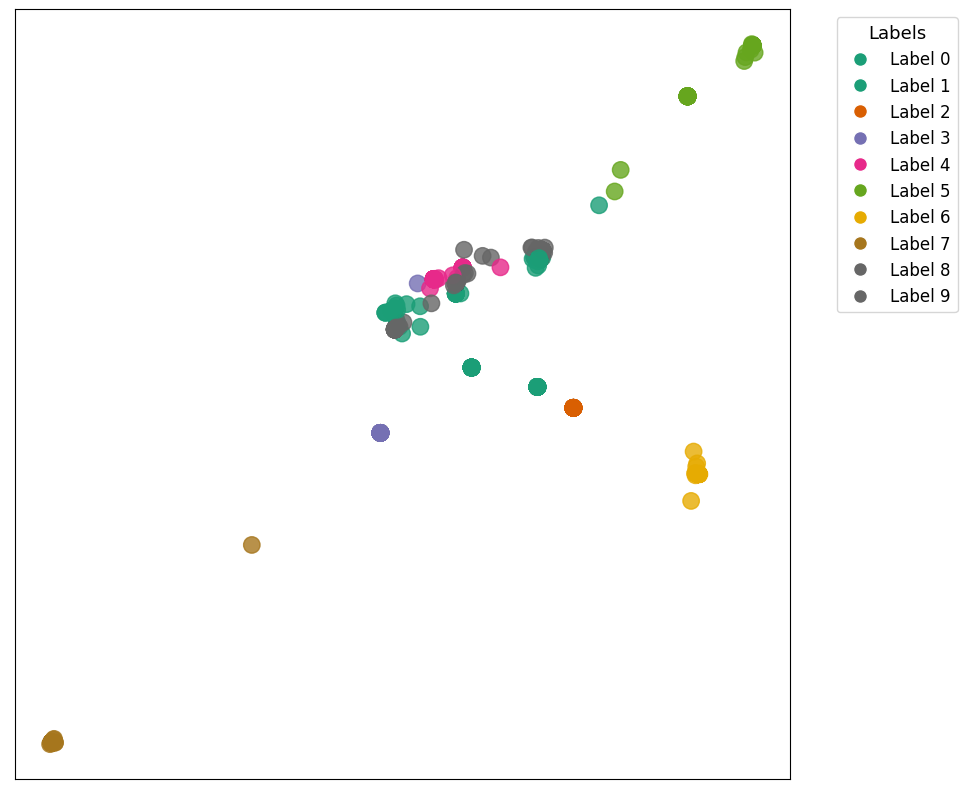

In [ ]:
visualize_embedding(tensor_test_embeddings, color)

c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


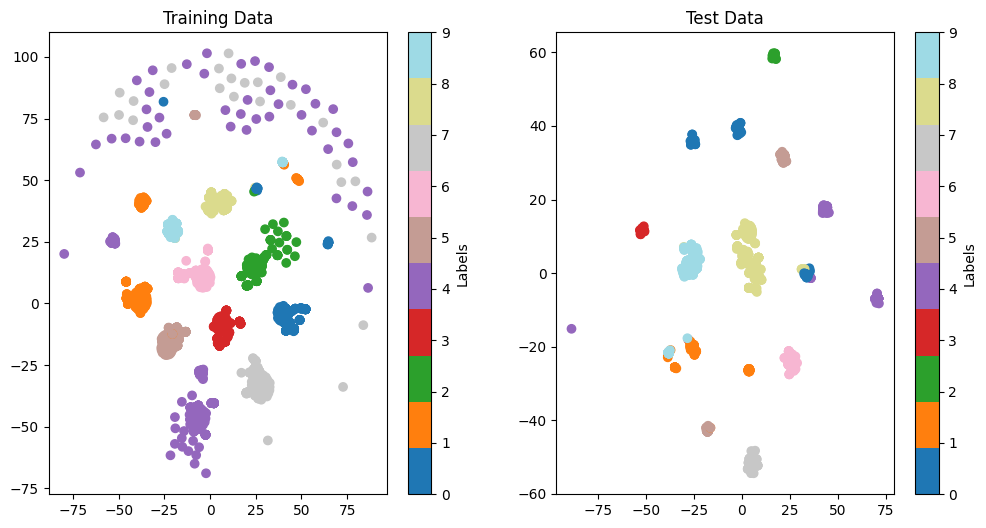

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

# Convert tensors to numpy arrays
h = torch.stack(tensor_train_embeddings).detach().cpu().numpy()
h1 = torch.stack(tensor_test_embeddings).detach().cpu().numpy()
color = np.array(train_data_lables)
color1 = np.array(test_data_lables)

# Apply TSNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # Set random_state for reproducibility
z = tsne.fit_transform(h)
y = tsne.fit_transform(h1)

# Define color maps and labels
unique_labels_train = np.unique(color)
unique_labels_test = np.unique(color1)

# Create a color map that can handle more unique labels
colormap_train = plt.cm.get_cmap('tab20', len(unique_labels_train))
colormap_test = plt.cm.get_cmap('tab20', len(unique_labels_test))

# Create subplots
plt.figure(figsize=(12, 6))

# Plot the training data
plt.subplot(1, 2, 1)
scatter_train = plt.scatter(z[:, 0], z[:, 1], c=color, cmap=colormap_train, marker='o')
plt.title('Training Data')
cbar = plt.colorbar(scatter_train, ticks=np.arange(len(unique_labels_train)))
cbar.set_label('Labels')
cbar.set_ticks(np.arange(len(unique_labels_train)))
cbar.set_ticklabels([str(label) for label in unique_labels_train])

# Plot the test data
plt.subplot(1, 2, 2)
scatter_test = plt.scatter(y[:, 0], y[:, 1], c=color1, cmap=colormap_test, marker='o')
plt.title('Test Data')
cbar = plt.colorbar(scatter_test, ticks=np.arange(len(unique_labels_test)))
cbar.set_label('Labels')
cbar.set_ticks(np.arange(len(unique_labels_test)))
cbar.set_ticklabels([str(label) for label in unique_labels_test])

plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

def classifier():
    print("Training classifier...")

    classifiers = [
        SVC(C=1.0, kernel='rbf'),
        RandomForestClassifier(n_estimators=100),
        GradientBoostingClassifier(n_estimators=100),
        KNeighborsClassifier(n_neighbors=5)
    ]

    # Ensure embeddings are of consistent shape
    # Detach tensors and convert to NumPy arrays
    train_embeddings_array = np.vstack([t.detach().cpu().numpy() for t in train_data_outs_embeddings])
    test_embeddings_array = np.vstack([t.detach().cpu().numpy() for t in test_data_outs_embeddings])

    # Debug print to check the labels
    print(f"Train labels type: {type(train_data_lables)}, Test labels type: {type(test_data_lables)}")
    
    # Check if labels are lists of arrays or tensors
    print(f"Train labels example: {train_data_lables[:2]}")
    print(f"Test labels example: {test_data_lables[:2]}")

    # Convert labels to arrays if necessary
    if isinstance(train_data_lables, (list, tuple)):
        Y_train = np.concatenate([np.array(lbl) for lbl in train_data_lables])
    else:
        Y_train = np.array(train_data_lables)

    if isinstance(test_data_lables, (list, tuple)):
        Y_test = np.concatenate([np.array(lbl) for lbl in test_data_lables])
    else:
        Y_test = np.array(test_data_lables)

    X_train = train_embeddings_array
    X_test = test_embeddings_array

    accuracies = {}

    for clf in classifiers:
        print(f"Testing with {clf.__class__.__name__}")
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies[clf.__class__.__name__] = accuracy
        print(f"Accuracy with {clf.__class__.__name__}: {accuracy:.5f}")

    return accuracies

def clustering():
    print("Performing clustering tasks...")

    # Ensure embeddings are of consistent shape
    # Detach tensors and convert to NumPy arrays
    train_embeddings_array = np.vstack([t.detach().cpu().numpy() for t in train_data_outs_embeddings])
    test_embeddings_array = np.vstack([t.detach().cpu().numpy() for t in test_data_outs_embeddings])

    # Debug print to check the labels
    print(f"Train labels type: {type(train_data_lables)}, Test labels type: {type(test_data_lables)}")
    
    # Check if labels are lists of arrays or tensors
    print(f"Train labels example: {train_data_lables[:2]}")
    print(f"Test labels example: {test_data_lables[:2]}")
    print()
    
    # Convert labels to arrays if necessary
    if isinstance(train_data_lables, (list, tuple)):
        Y_train = np.concatenate([np.array(lbl) for lbl in train_data_lables])
    else:
        Y_train = np.array(train_data_lables)

    if isinstance(test_data_lables, (list, tuple)):
        Y_test = np.concatenate([np.array(lbl) for lbl in test_data_lables])
    else:
        Y_test = np.array(test_data_lables)

    X_train = train_embeddings_array
    X_test = test_embeddings_array

    clustering_algorithms = [
        KMeans(n_clusters=len(np.unique(Y_train))),
        DBSCAN(eps=0.5, min_samples=5),
        AgglomerativeClustering(n_clusters=len(np.unique(Y_train)))
    ]
    
    cluster_scores = {}

    for algo in clustering_algorithms:
        print(f"Testing with {algo.__class__.__name__}")
        algo.fit(X_train)
        if hasattr(algo, 'labels_'):
            cluster_labels = algo.labels_
        else:
            raise NotImplementedError(f"{algo.__class__.__name__} does not have a labels_ attribute")

        silhouette_avg = silhouette_score(X_train, cluster_labels)
        rand_score = adjusted_rand_score(Y_train, cluster_labels)

        cluster_scores[algo.__class__.__name__] = {
            'Silhouette Score': silhouette_avg,
            'Adjusted Rand Index': rand_score
        }

        print(f"{algo.__class__.__name__} - Silhouette Score: {silhouette_avg:.5f}, Adjusted Rand Index: {rand_score:.5f}")

    return cluster_scores

# Example loop for training over multiple epochs
for epoch in range(1, 5):
    val_accuracies = classifier()
    for clf_name, acc in val_accuracies.items():
        print(f'Epoch {epoch}, {clf_name}: Val Accuracy: {acc:.5f}')

    cluster_results = clustering()
    for algo_name, scores in cluster_results.items():
        print(f'Epoch {epoch}, {algo_name}: Silhouette Score: {scores["Silhouette Score"]:.5f}, Adjusted Rand Index: {scores["Adjusted Rand Index"]:.5f}')


Training classifier...
Train labels type: <class 'torch.Tensor'>, Test labels type: <class 'torch.Tensor'>
Train labels example: tensor([7, 2])
Test labels example: tensor([3, 3])
Testing with SVC
Accuracy with SVC: 0.96304
Testing with RandomForestClassifier
Accuracy with RandomForestClassifier: 0.99708
Testing with GradientBoostingClassifier
Accuracy with GradientBoostingClassifier: 0.99708
Testing with KNeighborsClassifier
Accuracy with KNeighborsClassifier: 0.99416
Epoch 1, SVC: Val Accuracy: 0.96304
Epoch 1, RandomForestClassifier: Val Accuracy: 0.99708
Epoch 1, GradientBoostingClassifier: Val Accuracy: 0.99708
Epoch 1, KNeighborsClassifier: Val Accuracy: 0.99416
Performing clustering tasks...
Train labels type: <class 'torch.Tensor'>, Test labels type: <class 'torch.Tensor'>
Train labels example: tensor([7, 2])
Test labels example: tensor([3, 3])

Testing with KMeans
KMeans - Silhouette Score: 0.91024, Adjusted Rand Index: 0.84730
Testing with DBSCAN
DBSCAN - Silhouette Score: 0.

In [ ]:
#save model
MODEL_PATH = 'C:/env/model_GNN/save/model.pth'
torch.save(model, MODEL_PATH)
model=torch.load(MODEL_PATH)